# Chapter 6: Extracting Image Features and Descriptors


## Robust image matching using the RANSAC algorithm and Harris Corner features


### 1. Import Các thư viện cần thiết

In [ ]:
from matplotlib import pylab as pylab
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, SimilarityTransform, AffineTransform, resize
import cv2
import numpy as np
from skimage import data
from skimage.util import img_as_float
from skimage.exposure import rescale_intensity
from skimage.measure import ransac


temple = rgb2gray(img_as_float(imread('../images/temple.jpg')))












In [ ]:
image_original = np.zeros(list(temple.shape) + [3])
image_original[..., 0] = temple
gradient_row, gradient_col = (np.mgrid[0:image_original.shape[0], 0:image_original.shape[1]] / float(image_original.shape[0]))
image_original[..., 1] = gradient_row
image_original[..., 2] = gradient_col
image_original = rescale_intensity(image_original)
image_original_gray = rgb2gray(image_original)
affine_trans = AffineTransform(scale=(0.8, 0.9), rotation=0.1, translation=(120, -20))
image_warped = warp(image_original, affine_trans .inverse, output_shape=image_original.shape)
image_warped_gray = rgb2gray(image_warped)
coordinates = corner_harris(image_original_gray)
coordinates[coordinates > 0.01*coordinates.max()] = 1
coordinates_original = corner_peaks(coordinates, threshold_rel=0.0001, min_distance=5)
coordinates = corner_harris(image_warped_gray)
coordinates[coordinates > 0.01*coordinates.max()] = 1
coordinates_warped = corner_peaks(coordinates, threshold_rel=0.0001, min_distance=5)
coordinates_original_subpix = corner_subpix(image_original_gray, coordinates_original, window_size=9)
coordinates_warped_subpix = corner_subpix(image_warped_gray, coordinates_warped, window_size=9)


*   **image\_original = np.zeros(list(temple.shape) + \[3\])**: Tạo một mảng image\_original có kích thước giống như hình ảnh đầu vào temple, nhưng có 3 kênh (RGB), với giá trị ban đầu là 0.
    
*   **image\_original\[..., 0\] = temple**: Gán hình ảnh temple vào kênh màu đỏ (R) của ảnh image\_original.
    
*   **gradient\_row, gradient\_col = (np.mgrid\[0:image\_original.shape\[0\], 0:image\_original.shape\[1\]\] / float(image\_original.shape\[0\]))**: Tạo một lưới gradient cho các hàng (gradient\_row) và cột (gradient\_col) trong ảnh, với giá trị được chuẩn hóa theo kích thước ảnh.
    
*   **image\_original\[..., 1\] = gradient\_row**: Gán giá trị gradient theo hàng vào kênh màu xanh lá cây (G) của ảnh image\_original.
    
*   **image\_original\[..., 2\] = gradient\_col**: Gán giá trị gradient theo cột vào kênh màu xanh dương (B) của ảnh image\_original.
    
*   **image\_original = rescale\_intensity(image\_original)**: Chuẩn hóa lại cường độ ảnh image\_original (dải giá trị pixel từ 0 đến 1).
    
*   **image\_original\_gray = rgb2gray(image\_original)**: Chuyển ảnh image\_original từ RGB sang ảnh xám (grayscale) bằng hàm rgb2gray.
    
*   **affine\_trans = AffineTransform(scale=(0.8, 0.9), rotation=0.1, translation=(120, -20))**: Khởi tạo một phép biến đổi affine với các tham số:
    
    *   scale: Tỉ lệ co dãn theo chiều rộng 0.8 và chiều cao 0.9.
        
    *   rotation: Xoay ảnh một góc 0.1 radian.
        
    *   translation: Dịch chuyển ảnh 120 pixels theo chiều x và -20 pixels theo chiều y.
        
*   **image\_warped = warp(image\_original, affine\_trans.inverse, output\_shape=image\_original.shape)**: Áp dụng phép biến đổi affine ngược (inverse) lên ảnh image\_original để tạo ra ảnh biến dạng (image\_warped).
    
*   **image\_warped\_gray = rgb2gray(image\_warped)**: Chuyển ảnh biến dạng image\_warped sang ảnh xám.
    
*   **coordinates = corner\_harris(image\_original\_gray)**: Sử dụng phép toán Harris Corner Detection để tìm các điểm góc trong ảnh xám image\_original\_gray.
    
*   **coordinates\[coordinates > 0.01\*coordinates.max()\] = 1**: Đặt các giá trị lớn hơn 1% giá trị tối đa của coordinates thành 1 (đánh dấu các điểm góc có độ mạnh đáng chú ý)

In [ ]:

def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g_w = np.zeros(y.shape, dtype = np.double)
    g_w[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g_w /= 2 * np.pi * sigma * sigma
    return g_w

In [ ]:
def match_corner(coordinates, window_ext=3):
    row, col = np.round(coordinates).astype(np.intp)
    window_original = image_original[row-window_ext:row+window_ext+1, col-window_ext:col+window_ext+1, :]
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))
    SSDs = []
    for coord_row, coord_col in coordinates_warped:
        window_warped = image_warped[coord_row-window_ext:coord_row+window_ext+1,
        coord_col-window_ext:coord_col+window_ext+1, :]
        if window_original.shape == window_warped.shape:
            SSD = np.sum(weights * (window_original - window_warped)**2)
            SSDs.append(SSD)
    min_idx = np.argmin(SSDs) if len(SSDs) > 0 else -1
    return coordinates_warped_subpix[min_idx] if min_idx >= 0 else [None]

In [ ]:
from skimage.feature import (match_descriptors, corner_peaks, corner_harris, plot_matches, BRIEF)
source, destination = [], []
for coordinates in coordinates_original_subpix:
    coordinates1 = match_corner(coordinates)
    if any(coordinates1) and len(coordinates1) > 0 and not all(np.isnan(coordinates1)):
        source.append(coordinates)
        destination.append(coordinates1)
source = np.array(source)
destination = np.array(destination)
model = AffineTransform()
model.estimate(source, destination)
model_robust, inliers = ransac((source, destination), AffineTransform, min_samples=3, residual_threshold=2, max_trials=100)
outliers = inliers == False


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13928\1899005880.py:4: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  plot_matches(axes[0], image_original_gray, image_warped_gray, source, destination, np.column_stack((inlier_idxs, inlier_idxs)),matches_color='b')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13928\1899005880.py:7: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  plot_matches(axes[1], image_original_gray, image_warped_gray, source, destination, np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')


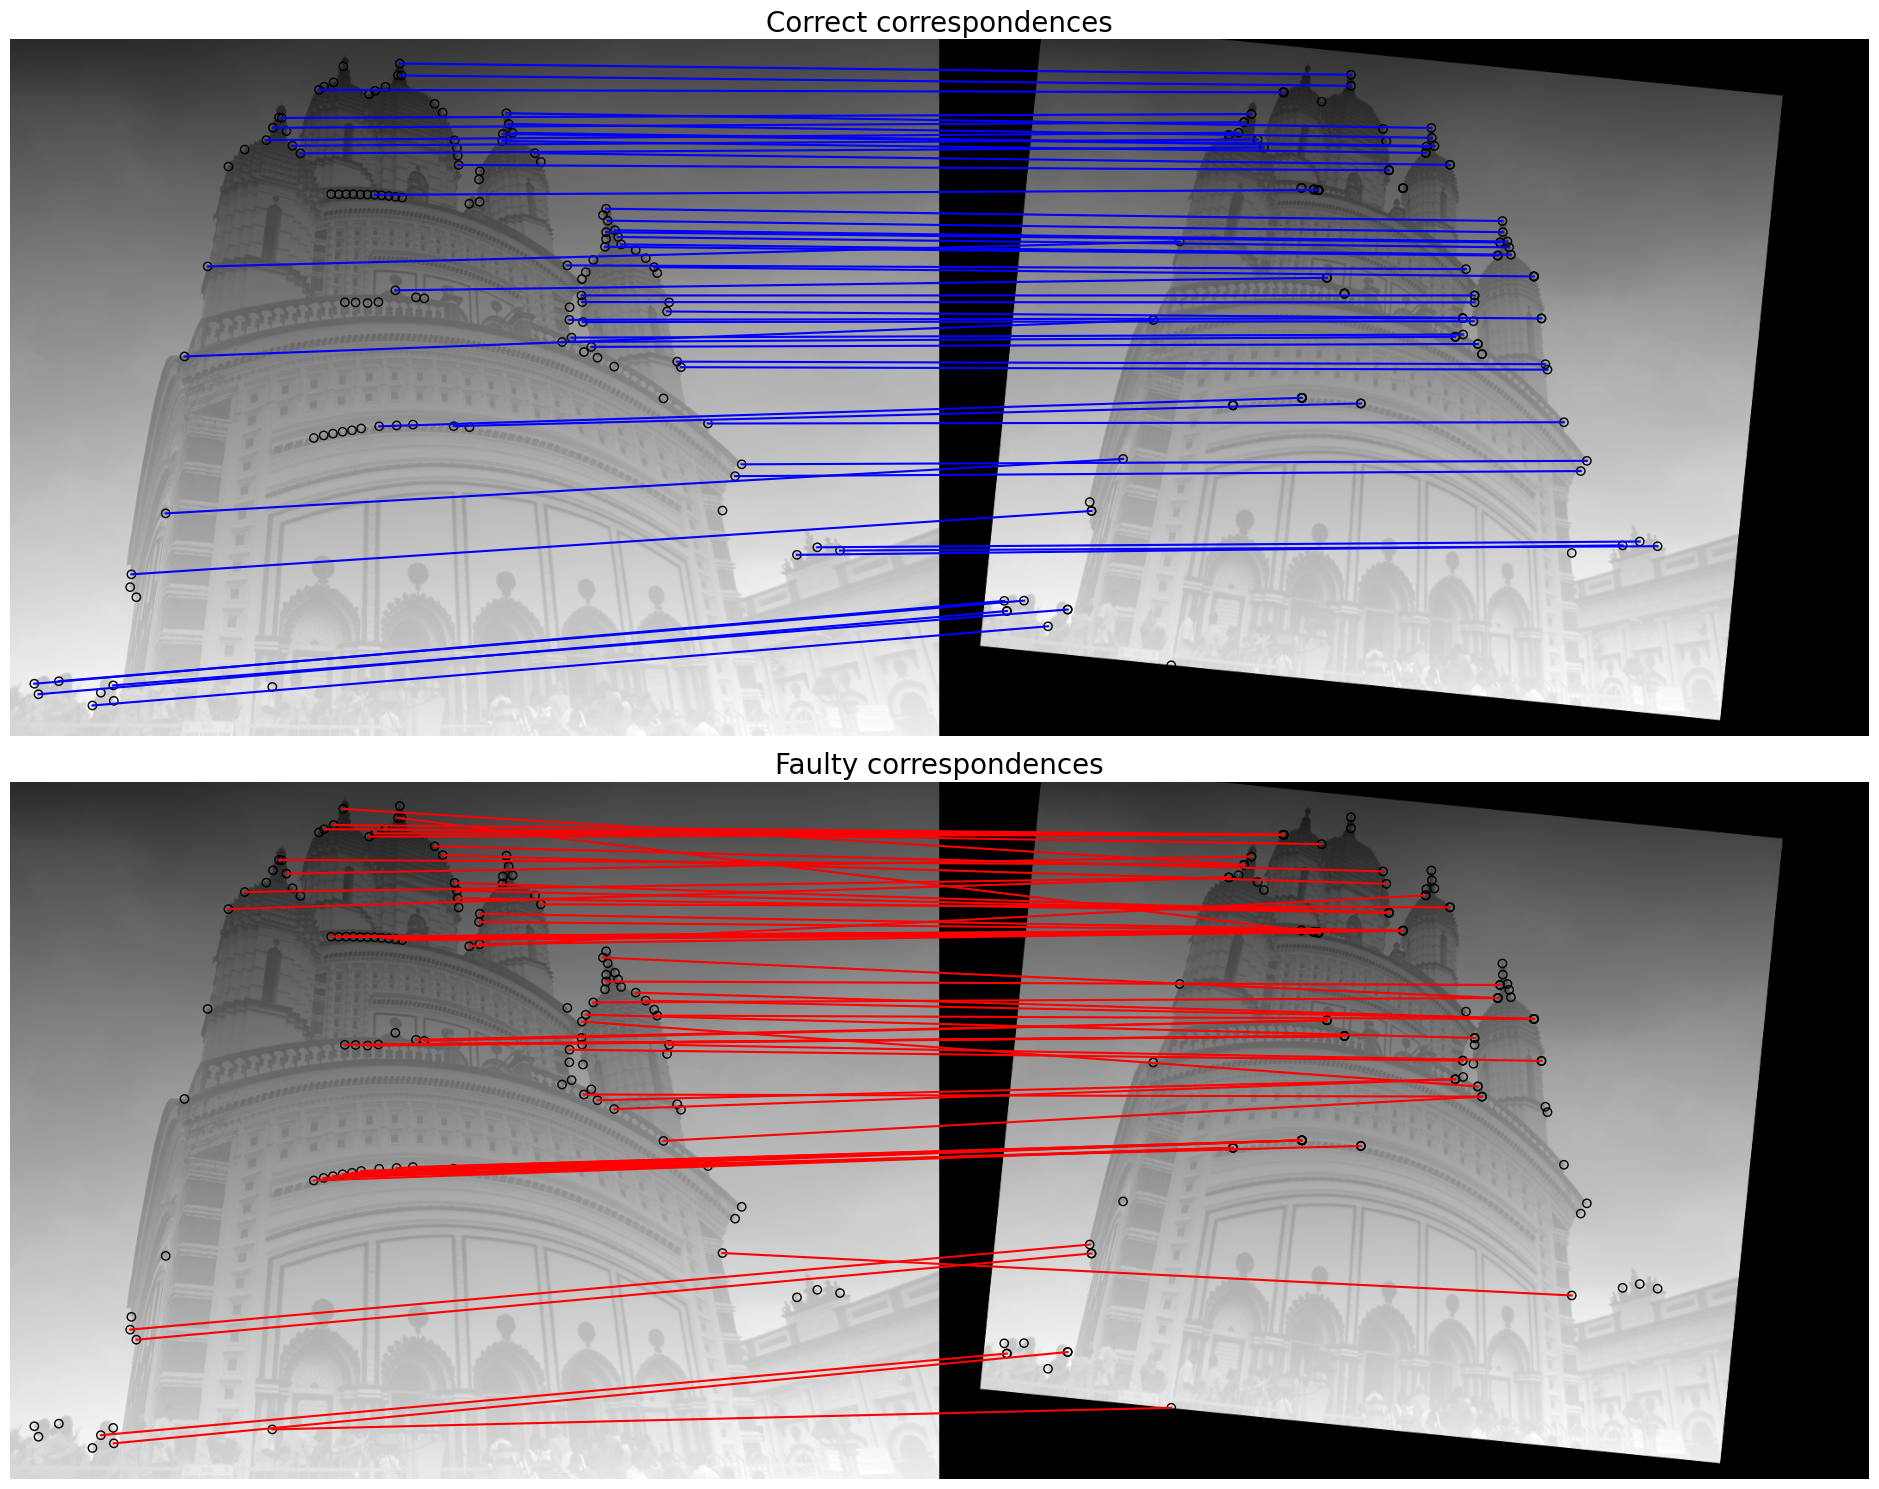

(None, None)

In [2]:

fig, axes = pylab.subplots(nrows=2, ncols=1, figsize=(20,15))
pylab.gray()
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(axes[0], image_original_gray, image_warped_gray, source, destination, np.column_stack((inlier_idxs, inlier_idxs)),matches_color='b')
axes[0].axis('off'), axes[0].set_title('Correct correspondences', size=20)
outlier_idxs = np.nonzero(outliers)[0]
plot_matches(axes[1], image_original_gray, image_warped_gray, source, destination, np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
axes[1].axis('off'), axes[1].set_title('Faulty correspondences', size=20)
fig.tight_layout(), pylab.show()

